# Wrangle Review Data

In [1]:
import numpy as np
import pandas as pd
import datetime
import json

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

TITLE_FONT_SIZE = 25
LABEL_FONT_SIZE = 15
TICK_FONT_SIZE  = 15

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

def time_marker(text=''):
    print('[{}] {}'.format(datetime.datetime.now().time(), text.lower()))

# Load Cleaned Business Data

In [3]:
business_data = pd.read_csv('../clean_data/business_clean.csv', index_col=0)
restaurant_bids = list(business_data.business_id.values)

## Load the Data

In [4]:
data = pd.DataFrame()
source_data_file = '../source_data/tip.json'

time_marker('loading source data file...')
biz_list = []
for line in open(source_data_file, 'r'):
    biz_list.append(json.loads(line))

time_marker('creating dataframe...')
data = pd.DataFrame(biz_list)

[23:02:38.654685] loading source data file...
[23:02:49.261062] creating dataframe...


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098325 entries, 0 to 1098324
Data columns (total 5 columns):
business_id    1098325 non-null object
date           1098325 non-null object
likes          1098325 non-null int64
text           1098325 non-null object
user_id        1098325 non-null object
dtypes: int64(1), object(4)
memory usage: 41.9+ MB


## Prune tips to only those for our restaurant subset

In [6]:
data = data[data.business_id.isin(restaurant_bids)].copy()
data.reset_index(inplace=True, drop=True)

In [7]:
time_marker(text='set index to business_id...')
data.set_index('business_id', inplace=True, drop=True)

[23:02:52.910064] set index to business_id...


## Prune tips that are less than less than 4 characters long, these rarely provide useful information

In [8]:
data = data[data.text.str.len() >= 4].copy()

## Sanitize tip text

In [9]:
import string
translator = str.maketrans('','', string.punctuation)

In [10]:
data['text'] = data['text'].apply(lambda text: text.translate(translator).lower())

## Cleanup columns and reset index

In [11]:
time_marker(text='cleaning up and reset index...')
data.columns = [str(x).lower().replace(' ', '_') for x in data.columns]
data.reset_index(inplace=True)

[23:02:54.562225] cleaning up and reset index...


## EDA Tip Text Length Distribution

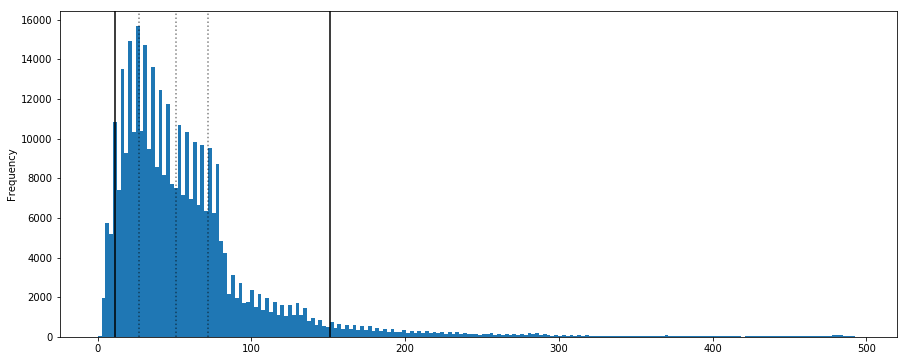

In [12]:
ax = data.text.str.len().plot(kind='hist', bins=200, figsize=(15,6))

ax.axvline(data.text.str.len().quantile(0.05), color='k')
ax.axvline(data.text.str.len().quantile(0.25), color='k', alpha=0.5, linestyle=':')
ax.axvline(data.text.str.len().quantile(0.55), color='k', alpha=0.5, linestyle=':')
ax.axvline(data.text.str.len().quantile(0.75), color='k', alpha=0.5, linestyle=':')
ax.axvline(data.text.str.len().quantile(0.95), color='k')

plt.show()
plt.close()

## Tokenize Tip Text, remove stop words

In [13]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [14]:
def tokenize_tip(text):
    tokens = [t for t in word_tokenize(text) if t.isalpha()]
    no_stops = [t for t in tokens if t not in stopwords.words('english')]
    return no_stops

In [15]:
data['tokenize_text'] = data.text.apply(lambda x: tokenize_tip(x))

In [16]:
data['word_count'] = data.tokenize_text.str.len()

## EDA Tip Word Count Distribution

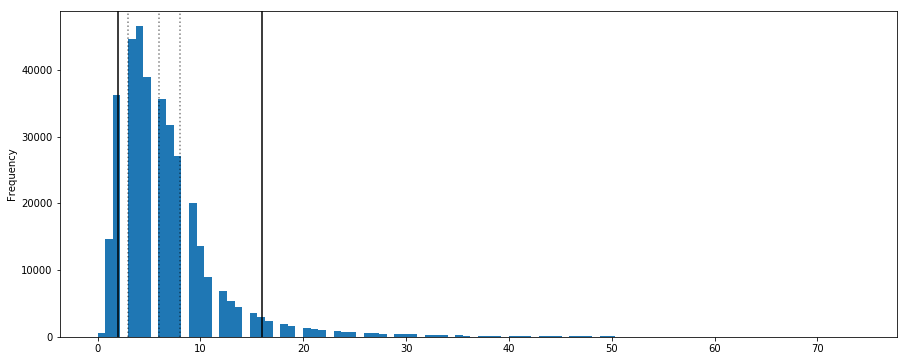

In [19]:
ax = data.word_count.plot(kind='hist', bins=100, figsize=(15,6))

ax.axvline(data.word_count.quantile(0.05), color='k')
ax.axvline(data.word_count.quantile(0.25), color='k', alpha=0.5, linestyle=':')
ax.axvline(data.word_count.quantile(0.55), color='k', alpha=0.5, linestyle=':')
ax.axvline(data.word_count.quantile(0.75), color='k', alpha=0.5, linestyle=':')
ax.axvline(data.word_count.quantile(0.95), color='k')

plt.show()
plt.close()

# Write to File

In [18]:
# file_name = '../clean_data/business_clean.csv'
# time_marker(text='Writing {:d} records to file {}'.format(data_pass3.shape[0], file_name))
# data_pass3.to_csv(file_name, encoding='utf-8')